# Searchlight classification of movie segments

In this analysis, we classify which segment (5 TRs) of the movie the participant was watching for each searchlight (20 mm radius).

## Preparations

### Import Python packages

In [1]:
import os
import numpy as np
from scipy.stats import ttest_rel, rankdata, pearsonr, spearmanr
import neuroboros as nb
from joblib import Parallel, delayed, cpu_count, parallel_backend

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

### Other settings

In [2]:
dsets = ['raiders', 'budapest']
ico = 32
spaces = [f'{a}-ico{b}' for a in ['fsavg', 'fslr', 'onavg'] for b in [ico]]
train_dur, test_dur = '1st-half', '2nd-half'
radius = 20
align_radius = 20
size = 5
colors = np.array(sns.color_palette('tab10'))
np.set_printoptions(4, linewidth=200)
if os.path.exists('Arial.ttf'):
    from matplotlib import font_manager
    font_manager.fontManager.addfont('Arial.ttf')
mpl.rcParams['font.family'] = 'Arial'

### Load results

In [3]:
# cache file to avoid excessive I/O
summary_fn = f'sl_clf/summary_ico{ico}_size{size}.pkl'
if not os.path.exists(summary_fn):
    results = {}
    for dset_name in dsets:
        dset = nb.dataset(dset_name)
        sids = dset.subjects
        for align in ['surf', 'procr', 'ridge']:
            for space in spaces:
                folder = f'sl_clf/{dset_name}/{space}_{align}_{align_radius}mm_'\
                    f'{train_dur}_{test_dur}_{size}TRs'
                aa = []
                for sid in sids:
                    a = [np.load(f'{folder}/{sid}_{lr}h_{radius}mm.npy')
                         for lr in 'lr']
                    a = np.concatenate(a)
                    aa.append(a)
                aa = np.array(aa)
                results[dset_name, space, align] = aa
    nb.save(summary_fn, results)
results = nb.load(summary_fn)

## Accuracy of movie time point classification
- Two datasets (top: _Raiders_, bottom: _Budapest_)
- Three alignment methods (surface alignment, Procrustes hyperalignment, warp hyperalignment)
- Bars denote average accuracy across participants and searchlights
- Grey lines denote individual participants (average accuracy across searchlights)

1.0 1.0 4.803615811053366e-07


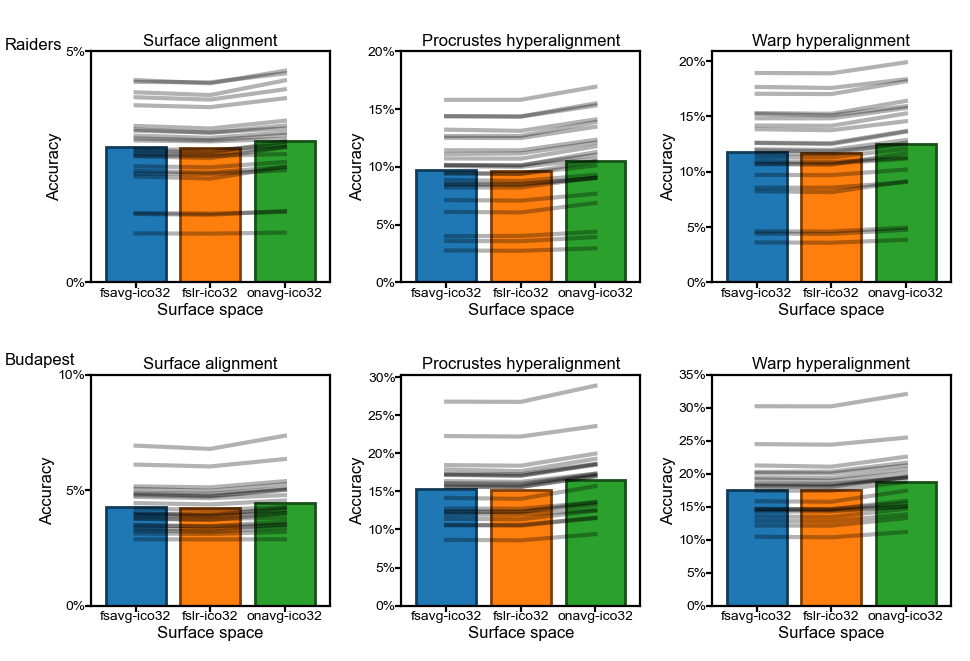

In [4]:
fig, axs = plt.subplots(2, 3, figsize=[_/2.54 for _ in (12, 8)], dpi=200)
pct1, pct2, pp = [], [], []
for ii, dset_name in enumerate(['raiders', 'budapest']):
    for jj, align in enumerate(['surf', 'procr', 'ridge']):
        ax = axs[ii, jj]
        ys = []
        for i, space in enumerate(spaces):
            a = results[dset_name, space, align].mean(axis=1)
            m = a.mean(axis=0)
            c = colors[i]
            ax.bar(i, m, facecolor=c, edgecolor=c*0.5, ecolor=c*0.5)
            ys.append(a)
        ax.set_xticks(np.arange(3), labels=spaces)

        ys = np.array(ys)
        for y in ys.T:
            ax.plot(np.arange(3), y, 'k-', alpha=0.3, markersize=1)
        t, p = ttest_rel(ys[2], ys[0])
        pp.append(p)
        assert p < 0.005
        t, p = ttest_rel(ys[2], ys[1])
        pp.append(p)
        assert p < 0.005
        pct1.append(np.mean(ys[0] < ys[2]))
        pct2.append(np.mean(ys[1] < ys[2]))

        max_ = int(np.ceil(ys.max() * 20))
        yy = np.arange(max_ + 1) * 0.05
        ax.set_yticks(yy, labels=[f'{_*100:.0f}%' for _ in yy])
        ax.set_xlim([-0.6, 2.6])
        ax.tick_params(axis='both', pad=0, length=2, labelsize=5)
        ax.set_ylabel('Accuracy', size=6, labelpad=1)
        ax.set_xlabel('Surface space', size=6, labelpad=1)
        title = {'procr': 'Procrustes hyperalignment',
                 'ridge': 'Warp hyperalignment',
                 'surf': 'Surface alignment'}[align]
        ax.set_title(f'{title}', size=6, pad=2)
    ax.annotate(dset_name.capitalize(), (0.005, 0.99 - ii * 0.5),
                xycoords='figure fraction', size=6, va='top')
print(np.mean(pct1), np.mean(pct2), np.max(pp))

fig.subplots_adjust(
    left=0.08, right=0.99, top=0.94, bottom=0.06, wspace=0.3, hspace=0.4)
plt.savefig('sl_clf_bar.png', dpi=300, transparent=True)
plt.show()

## Difference of classification accuracy between template spaces
- The difference accuracy between `onavg` and fsavg (blue bars), and between `onavg` and fslr (orange bars)
- The differences are statistically significant (_p_ < 1e-4) across different datasets and alignment methods

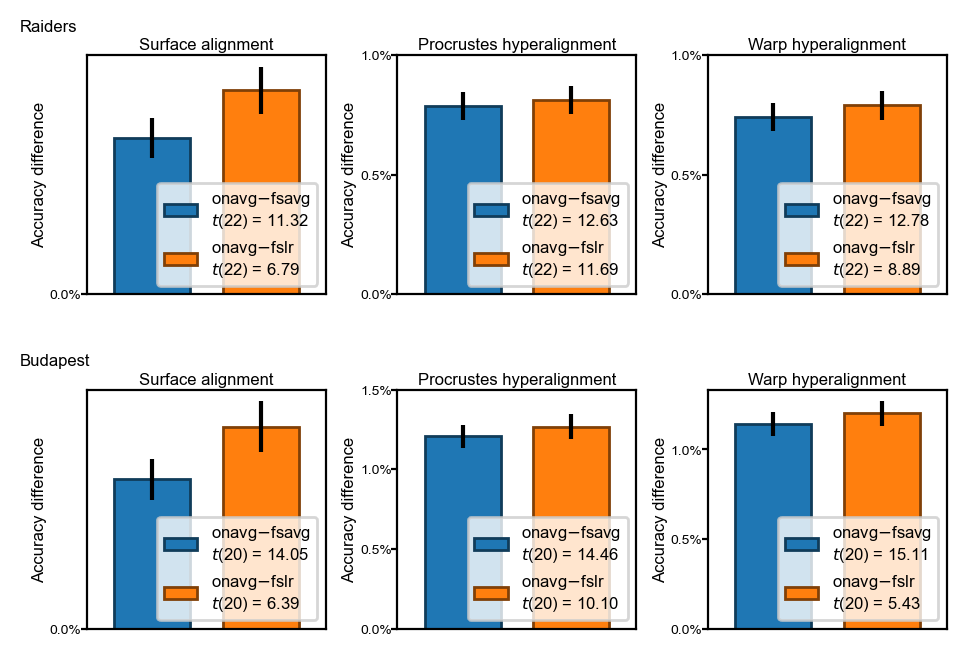

In [5]:
fig, axs = plt.subplots(
    2, 3, figsize=[_/2.54 for _ in (12, 8)], dpi=200)
pct1, pct2, pp = [], [], []
for ii, dset_name in enumerate(dsets):
    for jj, align in enumerate(['surf', 'procr', 'ridge']):
        ax = axs[ii, jj]
        max_ = []
        onavg = results[dset_name, spaces[-1], align].mean(axis=1)
        for kk, space in enumerate(spaces[:2]):
            y = onavg - results[dset_name, space, align].mean(axis=1)
            m = y.mean(axis=0)
            se = y.std(axis=0, ddof=1) / np.sqrt(y.shape[0])
            c = colors[kk]
            t, p = ttest_rel(onavg, results[dset_name, space, align][:, -1])
            dof = len(onavg) - 1
            label = f'{spaces[-1].split("-")[0]}$ - ${spaces[kk].split("-")[0]}'\
                    f'\n$t$({dof}) = {t:.2f}'
            ax.bar(kk, m, yerr=se, color=c, ec=c*0.5, width=0.7, label=label)
            max_.append(m + se)
            assert p < 1e-4
        max_ = int(np.ceil(np.max(max_) * 1.1 * 1000))

        ax.set_xticks([])
        ax.set_xlim(np.array([-0.6, 1.6]))
        yy = np.arange(0, max_ + 1, 5)
        ax.set_yticks(yy  * 0.001, labels=[f'{_*0.1:.1f}%' for _ in yy])
        ax.set_ylabel('Accuracy difference', size=6, labelpad=1)
        ax.tick_params(axis='both', pad=0, length=2, labelsize=5)

        title = {'procr': 'Procrustes hyperalignment',
                 'ridge': 'Warp hyperalignment',
                 'surf': 'Surface alignment',
                }[align]
        ax.set_title(f'{title}', size=6, pad=2)
        ax.legend(fontsize=6, fancybox=True, loc='lower right')
    axs[ii, 0].annotate(
        dset_name.capitalize(), (-0.28, 1.15),
        xycoords='axes fraction', size=6, va='top', ha='left')
fig.subplots_adjust(
    left=0.08, right=0.99, top=0.93, bottom=0.02, wspace=0.3, hspace=0.4)
plt.savefig('sl_clf_bar_diff.png', dpi=300, transparent=True)
plt.show()

## Which brain region has the most improvement

### Upsample the data
- To compare the results based on different template spaces, we upsample the statistics to `onavg-ico128` space

In [6]:
upsampled = {}
for ii, dset_name in enumerate(['raiders', 'budapest']):
    for jj, align in enumerate(['surf', 'procr', 'ridge']):
        for space in spaces:
            a = results[dset_name, space, align].mean(axis=0)
            center_space = space.split('-')[0] + '-ico32'
            xfms = [nb.mapping(lr, center_space, 'onavg-ico128', mask=True)
                    for lr in 'lr']
            nv1 = xfms[0].shape[0]
            a = np.concatenate([a[:nv1] @ xfms[0], a[nv1:] @ xfms[1]])
            upsampled[dset_name, space, align] = a

In [7]:
upsampled_ivd = {}
for space in spaces:
    center_space = space.split('-')[0] + '-ico32'
    ivd_lr = []
    for lr in 'lr':
        coords, faces = nb.geometry('midthickness', lr, center_space)
        surf = nb.Surface(coords, faces)
        distances = nb.distances(lr, center_space)
        mask = nb.mask(lr, space=center_space)
        ivd = []
        for i, nbrs in enumerate(surf.neighbors):
            if mask[i]:
                ivd.append(distances[i, nbrs].mean())
        ivd_lr.append(np.array(ivd))

    values = []
    for lr, ivd in zip('lr', ivd_lr):
        sls = nb.sls(lr, radius, space=space)
        avg_ivd = np.array([ivd[sl].mean() for sl in sls])

        xfm = nb.mapping(lr, center_space, 'onavg-ico128', mask=True)
        values.append(avg_ivd @ xfm)
    upsampled_ivd[space] = np.concatenate(values)

### Correlations with improvement in accuracy

- Regions that were previously undersampled are more likely to have more improvement after switching to onavg (`pearsonr(c, d)` in the code below).
- Regions that have higher accuracies based on traditional templates are more likely to have more improvement after switching to onavg (`pearsonr(a, d)` in the code below).

In [8]:
for space in spaces[:2]:
    for ii, dset_name in enumerate(['raiders', 'budapest']):
        for jj, align in enumerate(['surf', 'procr', 'ridge']):
            a = upsampled[dset_name, space, align]
            b = upsampled[dset_name, spaces[-1], align]
            c = upsampled_ivd[space]
            d = b - a
            print(f'{space:11s}, {dset_name:8s}, {align:5s}, '
                  f'{pearsonr(c, d)[0]:7.4f}, {pearsonr(a, d)[0]:7.4f}')

fsavg-ico32, raiders , surf , -0.0902, -0.0007
fsavg-ico32, raiders , procr,  0.2385,  0.4536
fsavg-ico32, raiders , ridge,  0.4063,  0.4944
fsavg-ico32, budapest, surf , -0.1182, -0.0443
fsavg-ico32, budapest, procr,  0.2056,  0.3686
fsavg-ico32, budapest, ridge,  0.4501,  0.3976
fslr-ico32 , raiders , surf , -0.1038,  0.0102
fslr-ico32 , raiders , procr,  0.2697,  0.4402
fslr-ico32 , raiders , ridge,  0.4472,  0.5102
fslr-ico32 , budapest, surf , -0.0832,  0.0718
fslr-ico32 , budapest, procr,  0.2601,  0.3916
fslr-ico32 , budapest, ridge,  0.4820,  0.4256


### Scatter plots

In [9]:
nc = 10
colors2 = np.concatenate(
    [sns.color_palette("mako", nc)[1:],
     [[0.9, 0.9, 0.9]],
     sns.color_palette("rocket", nc)[1:][::-1]],
    axis=0)
cmap = mpl.colors.LinearSegmentedColormap.from_list('mako_rocket', colors2)

In the figure below, red dots are searchlights that have larger inter-vertex distance based on traditional templates, and blue dots are those that lave smaller inter-vertex distance. Dots above the diagonal are searchlights that improve after switching to `onavg`, and red dots appear more often above the diagonal.

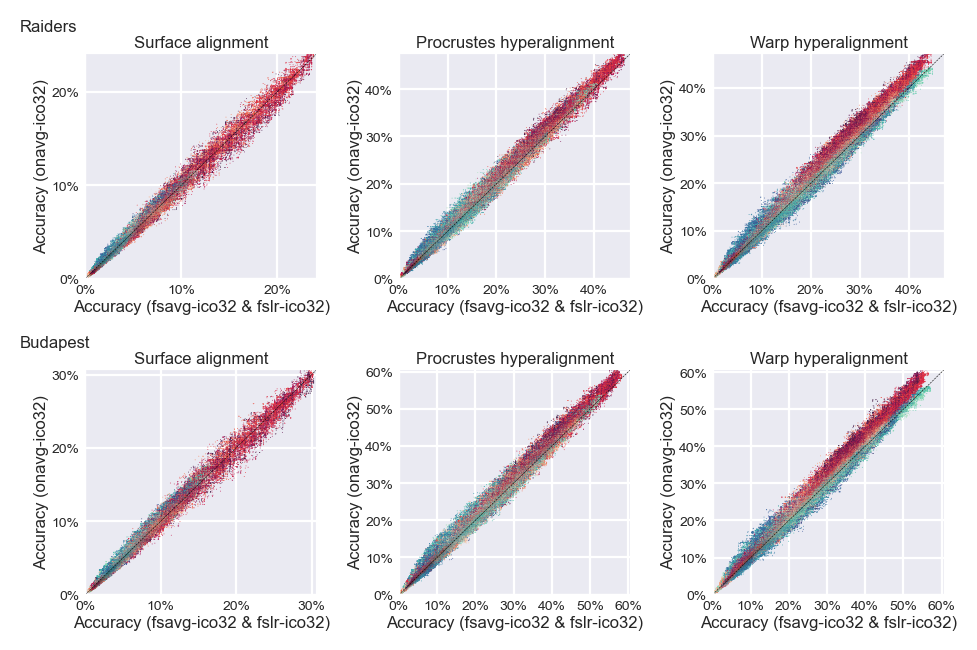

In [10]:
with sns.axes_style('darkgrid'):
    fig, axs = plt.subplots(2, 3, figsize=[_/2.54 for _ in (12, 8)], dpi=200)
    for ii, dset_name in enumerate(['raiders', 'budapest']):
        for jj, align in enumerate(['surf', 'procr', 'ridge']):
            aa, bb, cc = [], [], []
            for space in spaces[:2]:
                a = upsampled[dset_name, space, align]
                b = upsampled[dset_name, spaces[-1], align]
                c = upsampled_ivd[space]
                aa.append(a)
                bb.append(b)
                cc.append(c)
            aa = np.concatenate(aa)
            bb = np.concatenate(bb)
            cc = np.concatenate(cc)
            cc = cc - np.median(cc)
            vmax = np.percentile(cc, [99])
            idx = np.argsort(bb - aa)
            aa, bb, cc = aa[idx], bb[idx], cc[idx]
            ax = axs[ii, jj]
            ax.scatter(aa, bb, c=cc, s=0.1, edgecolor='none',
                       cmap=cmap, vmin=-vmax, vmax=vmax)
            lim = [0, max(a.max(), b.max())]
            ticks = np.arange(0, np.ceil(lim[1] * 100) + 1, 10) * 0.01
            labels = [f'{_*100:.0f}%' for _ in ticks]
            ax.set_xticks(ticks, labels=labels)
            ax.set_yticks(ticks, labels=labels)
            ax.set_xlim(lim)
            ax.set_ylim(lim)
            ax.plot(lim, lim, 'k--', alpha=1, lw=0.2)
            ax.tick_params(axis='both', pad=0, length=2, labelsize=5)
            ax.set_ylabel(f'Accuracy ({spaces[-1]})', size=6, labelpad=1)
            ax.set_xlabel(f'Accuracy ({" & ".join(spaces[:-1])})',
                          size=6, labelpad=1)
            title = {'procr': 'Procrustes hyperalignment',
                     'ridge': 'Warp hyperalignment',
                     'surf': 'Surface alignment',
                    }[align]
            ax.set_title(f'{title}', size=6, pad=2)
        axs[ii, 0].annotate(
            dset_name.capitalize(), (-0.28, 1.15),
            xycoords='axes fraction', size=6, va='top', ha='left')
    fig.subplots_adjust(
        left=0.08, right=0.99, top=0.92, bottom=0.06, wspace=0.35, hspace=0.4)
    plt.savefig('sl_clf_scatter.png', dpi=300)
    plt.show()